In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
from gymnasium.wrappers import RecordVideo
import time
import pickle as pkl
import os

In [37]:

class Genome:

    INPUT_SHAPE = 105
    OUTPUT_SHAPE = 8
    NEURON_COUNT = 512
    LAYER_COUNT = 5 #includes input and output layer
    MUTATION_EPSILON = 0.01 #chance to mutate (default value if not passed in)
    MUTATION_FACTOR = 0.05 #chance for each neuron to be mutated (USED VALUE)
    MUTATION_MULT_DIST = [1, 0.2]
    MUTATION_ADD_DIST = [0, 0.1]
    INITIAL_RANGE = [-3, 3]

    def __init__(self, weights=None, biases=None, activation=None):
        assert weights and biases and activation, "Must provide both weights and biases"
        assert len(weights) == len(biases), "Length of weights and biases do not match up!"
        assert biases[0].shape[0] == weights[0].shape[0], f"Shape mismatch when creating genome. Biases: {biases[0].shape[0]}, Weights: {weights[0].shape[0]}, Layer {0}"
        out_shape = weights[0].shape[0]
        for i, weight_list in enumerate(weights[1:]):
            assert weight_list.shape[1] == out_shape, f"Shape mismatch when creating genome. Weights: {weight_list.shape[1]}, {out_shape}. Layer {i}"
            assert biases[i+1].shape[0] == weight_list.shape[0], f"Shape mismatch when creating genome. Biases: {biases[i].shape[0]}, Weights: {weight_list.shape[0]}, Layer {i+1}"
            out_shape = weight_list.shape[0]

        self.weights = weights
        self.biases = biases
        self.activation = activation
        self.age = 0

    def relu(x):
        return np.maximum(0, x)

    def create_random():
        #Creates a random genome
        # TODO: If training is unstable, look into layer normalization
        weights = []
        biases = []
        last_shape = Genome.INPUT_SHAPE
        for i in range(Genome.LAYER_COUNT):
            if i == Genome.LAYER_COUNT-1:
                num_neurons = Genome.OUTPUT_SHAPE
            else:
                num_neurons = Genome.NEURON_COUNT
            
            weights.append(np.random.uniform(*Genome.INITIAL_RANGE, size=(num_neurons, last_shape)))
            biases.append(np.random.uniform(*Genome.INITIAL_RANGE, size=(num_neurons)))
            last_shape = biases[-1].shape[0]
            
        return Genome(weights, biases, Genome.relu)
    
    def simulate(self, env):
        observation, info = env.reset()
        done, truncated = False, False
        total_reward = 0
        while not done and not truncated:
            action = self.forward(observation)
            observation, reward, done, truncated, info = env.step(action)
            total_reward += reward
        self.age += 1
        return total_reward
            
    
    def forward(self, X):
        #Forward pass of network, computes action 
        for i in range(len(self.weights) - 1):
            X = self.activation(np.dot(self.weights[i], X) + self.biases[i])
        #TODO: Change final activation function depending on task
        X = np.tanh(np.dot(self.weights[-1], X) + self.biases[-1])
        return X

    def mutate(val):
        selection = np.random.choice(['multiply', 'add', 'reset'], p=[0.495, 0.495, 0.01])
        if selection == 'multiply':
            mult = np.random.normal(*Genome.MUTATION_MULT_DIST, size=val.shape)
            mult *= np.random.choice([1, -1], size=val.shape)
            return val * mult
        elif selection =='add':
            add = np.random.normal(*Genome.MUTATION_ADD_DIST, size=val.shape)
            return val + add
        elif selection == 'reset':
            return np.random.uniform(*Genome.INITIAL_RANGE, size=val.shape)

    def breed(self, other, mutation_rate=None):
        """
        Combines two genomes into one child genome using node-level crossover
            NOTE: separates weight from bias during selection, allowing mixing between parents 
        Also handles mutations
        """
        if mutation_rate == None:
            mutation_rate = Genome.MUTATION_EPSILON
        
        mutate = np.random.rand() <= mutation_rate

        child_weights, child_biases = [], []
        last_shape = Genome.INPUT_SHAPE
        for i in range(len(self.weights)):
            a_weights, a_biases = self.weights[i], self.biases[i]
            b_weights, b_biases = other.weights[i], other.biases[i]
            num_neurons = a_weights.shape[0]
            layer_weights = np.zeros((num_neurons, last_shape), dtype=float)
            layer_biases = np.zeros(num_neurons)
            for neuron_idx in range(num_neurons):
                selected_weight = a_weights[neuron_idx] if np.random.rand() < .5 else b_weights[neuron_idx]
                selected_bias = a_biases[neuron_idx] if np.random.rand() < .5 else b_biases[neuron_idx]

                if mutate and np.random.rand() <= Genome.MUTATION_FACTOR:
                    selected_weight = Genome.mutate(selected_weight)
                if mutate and np.random.rand() <= Genome.MUTATION_FACTOR:
                    selected_bias = Genome.mutate(selected_bias)
                
                try:
                    layer_weights[neuron_idx] = selected_weight
                    layer_biases[neuron_idx] = selected_bias
                except Exception as e:
                    print(layer_weights.shape)
                    print(selected_weight.shape)
                    print(layer_biases.shape)
                    print(selected_bias.shape)
                    raise e
            child_weights.append(layer_weights)
            child_biases.append(layer_biases)
            last_shape = num_neurons

        return Genome(child_weights, child_biases, Genome.relu)


In [123]:
class Population:

    MUTATION_DECAY_RATE = 0.01
    
    def __init__(self, env, name, pop_size=10_000, elite_ratio=0.01):
        self.pop_size = pop_size
        self.env = env
        self.name=name
        self.save_folder = f'./gnn_{self.name}'
        self.env_name = f'{env.spec.name}-v{env.spec.version}'
        Genome.INPUT_SHAPE = env.observation_space.shape[0]
        Genome.OUTPUT_SHAPE = env.action_space.shape[0]
        self.pop = self.generate_initial_population()
        self.elite_size = int(self.pop_size * elite_ratio)
        self.average_elite_scores = []
        self.average_scores = []
    
    def generate_initial_population(self):
        return [Genome.create_random() for _ in range(self.pop_size)]
    
    def score_pop(self):
        pop_scored = [(i, genome.simulate(self.env)) for i, genome in enumerate(self.pop)]
        pop_scored = sorted(pop_scored, key=lambda tup: tup[1], reverse=True)
        return zip(*pop_scored)
    
    
    def tournament_selection(self, scores, indexes, k=4):
        parents = []
        for _ in range(self.pop_size):
            # Randomly select k individuals
            tournament_indices = np.random.choice(indexes, k, replace=False)
            # Choose the best one
            best_index = max(tournament_indices, key=lambda i: scores[i])
            parents.append(self.pop[best_index])
        return parents


    def next_generation(self, mutation_rate=None):
        index_order, scores = self.score_pop()
        scores = np.array(scores)
        best = self.pop[index_order[0]]
        #add scores to record
        self.average_elite_scores.append(scores[:self.elite_size].mean())
        self.average_scores.append(scores.mean())
        scores = scores - scores.min() #adjust for negative values so that weights are built correctly
        weights = scores / scores.sum()
        mating_pool_idx = np.random.choice(index_order, p=weights, size=self.pop_size)
        mating_pool_idx[:self.elite_size] = index_order[:self.elite_size]
        children = []
        for _ in range(self.pop_size):
            a_parent, b_parent = np.random.choice(mating_pool_idx, size=2)
            while a_parent == b_parent: #prevent inbreeding (duplicating non-elites across generations)
                a_parent, b_parent = np.random.choice(mating_pool_idx, size=2)
            
            children.append(self.pop[a_parent].breed(self.pop[b_parent], mutation_rate=mutation_rate))
        self.pop = children
        return best

    def plot(self, last=False):
        fig = plt.figure(1)
        generations = np.arange(1, len(self.average_elite_scores) + 1)
        plt.clf()
        plt.title('Generation Score')
        plt.xlabel('Generation')
        plt.ylabel('Average Score')
        plt.plot(generations, self.average_elite_scores, label='Elites', color='red')
        plt.plot(generations, self.average_scores, label='Population', color='orange')
        plt.legend()
        plt.pause(0.001)
        display.display(plt.gcf())
        if not last:
            display.clear_output(wait=True)
        else:
            plt.savefig(os.path.join(self.save_folder, 'homebrew_training.png'))
    
    def save_video(self, best, generation):
        record_env = RecordVideo(gym.make(self.env_name, render_mode='rgb_array'), video_folder=self.save_folder, episode_trigger=lambda e: True, name_prefix=f'{self.env.spec.name}-gen{generation}')
        observation, info = record_env.reset()
        done, truncated = False, False
        total_reward = 0
        while not done and not truncated:
            action = best.forward(observation)
            observation, reward, done, truncated, info = record_env.step(action)
            total_reward += reward
        print(total_reward)
            
        record_env.close()
        
    def iterate_generations(self, amount, mutation_start=0.3, mutation_end=0.05):
        if not os.path.exists(self.save_folder):
            os.makedirs(self.save_folder)
        for generation in range(amount):
            mutation_rate = max(mutation_end, mutation_start * np.exp(-1 * generation * Population.MUTATION_DECAY_RATE))
            best = self.next_generation(mutation_rate=mutation_rate)
            self.plot()
            if (generation + 1) % 100 == 0:
                self.save_video(best, generation+1)
        
        with open(os.path.join(self.save_folder, 'genome.pkl'), mode='wb+') as f:
            pkl.dump(best, f)
        self.plot(last=True)



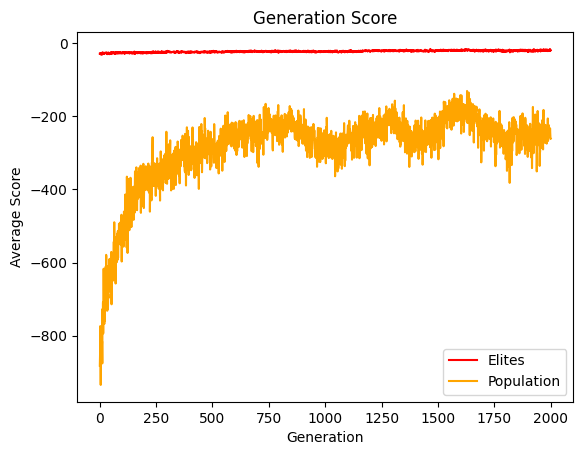

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [41]:
env = gym.make('Ant-v5')

population = Population(env, pop_size=500)

population.iterate_generations(2000)

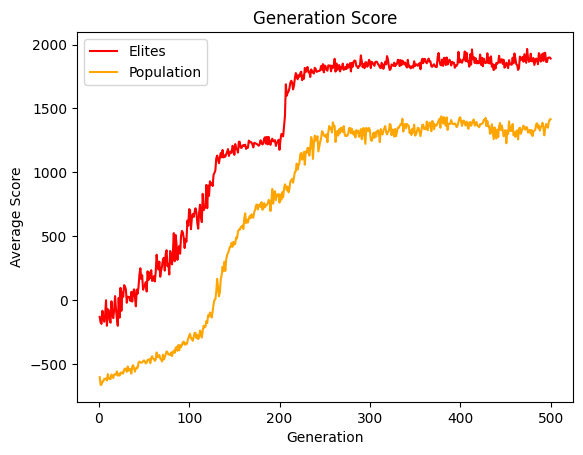

In [ ]:
env = gym.make('HalfCheetah-v5')

population = Population(env, pop_size=250)

population.iterate_generations(500)

In [124]:
env = gym.make('HalfCheetah-v5')

population = Population(env, 'longtrain', pop_size=500)

population.iterate_generations(2000)

KeyboardInterrupt: 